referencing:

https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d


In [ ]:
import os
os.kill(os.getpid(), 9)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%env AWS_ACCESS_KEY_ID=""
%env AWS_SECRET_ACCESS_KEY_ID=""
%env AWS_REGION_NAME=""
%env AWS_BUCKET_NAME=""

%env MODEL_VERSION=1

env: AWS_ACCESS_KEY_ID=""
env: AWS_SECRET_ACCESS_KEY_ID=""
env: AWS_REGION_NAME=""
env: AWS_BUCKET_NAME=""
env: MODEL_VERSION=1


In [4]:
# cmd to check gpu process
!nvidia-smi

Wed May 14 05:22:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text==2.12.0

In [6]:
!pip install -q tf-models-official==2.7.0

In [7]:
!pip install boto3

In [9]:
!pip install numpy==1.23.5

In [10]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [13]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/PBL5/restnest_chatbot_dataset.csv')

data = data[data['intent']!='FALLBACK']
data = data[data['intent']!='FORBIDDEN']
data = data[~data['intent'].str.startswith("OTHERS_")]

df = pd.DataFrame(data)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['intent'])

num_of_classes = len(le.classes_)

from sklearn.model_selection import train_test_split
y = tf.keras.utils.to_categorical(le.transform(df["intent"]))
x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)


print(len(df))
print(le.classes_)
df

21
['ASK_AMENITY' 'ASK_BOOKING_CANCEL' 'ASK_BOOKING_STATUS' 'ASK_CATEGORY'
 'ASK_CHAT_HISTORY' 'ASK_COUNTRY' 'ASK_FAVORITE' 'ASK_FAVORITE_VIEW'
 'ASK_IMAGE' 'ASK_LISTING_CAPACITY' 'ASK_LISTING_DETAIL'
 'ASK_PAYMENT_CONFIRM' 'ASK_PAYMENT_METHOD' 'ASK_REVIEW' 'ASK_REVIEW_EDIT'
 'ASK_SUPPORT' 'ASK_USER_PASSWORD' 'ASK_USER_PROFILE']


,intent,text,reply
0,ASK_AMENITY,Phòng có wifi không?,"Dạ có, tất cả phòng đều có wifi miễn phí."
1,ASK_AMENITY,Homestay có máy giặt không?,"Dạ có, homestay có máy giặt cho khách sử dụng."
2,ASK_AMENITY,Có chỗ đỗ xe miễn phí không?,"Dạ có, bạn được sử dụng chỗ đỗ xe miễn phí tại..."
3,ASK_LISTING_DETAIL,Homestay ở khu nào?,Bạn có thể chọn homestay tại nhiều khu vực khá...
4,ASK_LISTING_CAPACITY,Một phòng chứa được bao nhiêu người?,"Sức chứa tùy vào loại phòng, thường từ 2 đến 6..."
5,ASK_CATEGORY,Có loại chỗ ở nào phù hợp với gia đình không?,"Dạ có, bạn có thể chọn loại chỗ ở như căn hộ h..."
6,ASK_CATEGORY,Có phòng dorm không?,"Dạ có, chúng tôi có loại phòng dorm phù hợp vớ..."
7,ASK_BOOKING_STATUS,Làm sao để kiểm tra tình trạng đặt phòng?,Bạn có thể kiểm tra trong mục 'Đơn đặt phòng' ...
8,ASK_BOOKING_CANCEL,Hủy đặt phòng như thế nào?,Bạn có thể hủy trong phần chi tiết đặt phòng n...
9,ASK_USER_PROFILE,Làm sao để đổi tên tài khoản?,Bạn có thể vào mục 'Tài khoản' để chỉnh sửa tê...


In [14]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"

# only chinese model
#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [16]:
text_test = ['apple a p p l e']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 72894 10284   169   184   184   180   173   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
def build_classifier_model():
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  # comment out dropout layer as we have underfitting
  # net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [18]:
# custom sequence length
"""
def build_classifier_model():
  preprocessor = hub.load(tfhub_handle_preprocess)
  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]
  tokenize = hub.KerasLayer(preprocessor.tokenize)
  tokenized_inputs = [tokenize(segment) for segment in text_input]
  seq_length = 80  # Your choice here.
  bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length), name='preprocessing')
  encoder_inputs = bert_pack_inputs(tokenized_inputs)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)
"""

"\ndef build_classifier_model():\n  preprocessor = hub.load(tfhub_handle_preprocess)\n  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]\n  tokenize = hub.KerasLayer(preprocessor.tokenize)\n  tokenized_inputs = [tokenize(segment) for segment in text_input]\n  seq_length = 80  # Your choice here.\n  bert_pack_inputs = hub.KerasLayer(\n    preprocessor.bert_pack_inputs,\n    arguments=dict(seq_length=seq_length), name='preprocessing') \n  encoder_inputs = bert_pack_inputs(tokenized_inputs)\n  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  #net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)\n  return tf.keras.Model(text_input, net)\n"

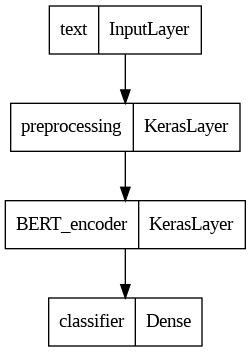

In [19]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)


In [20]:
classifier_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
"""
epochs = 5
steps_per_epoch = num_of_classes
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
print(steps_per_epoch)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
"""

"\nepochs = 5\nsteps_per_epoch = num_of_classes\nnum_train_steps = steps_per_epoch * epochs\nnum_warmup_steps = int(0.1*num_train_steps)\nprint(steps_per_epoch)\n\ninit_lr = 3e-5\noptimizer = optimization.create_optimizer(init_lr=init_lr,\n                                          num_train_steps=num_train_steps,\n                                          num_warmup_steps=num_warmup_steps,                                          \n                                          optimizer_type='adamw')\n"

In [22]:
from tensorflow.keras.optimizers import Adam
classifier_model.compile(Adam(learning_rate=3e-5), loss = "categorical_crossentropy", metrics = ["accuracy"]) # learning_rate recommand from the paper
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [33]:
n_epochs = 30

model_fit = classifier_model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    validation_data=(x_test, y_test),
    verbose=1
)


Epoch 1/30
1/1 [==============================] - 18s 18s/step - loss: 2.6279 - accuracy: 0.2667 - val_loss: 3.0006 - val_accuracy: 0.1667
Epoch 2/30
1/1 [==============================] - 17s 17s/step - loss: 2.4979 - accuracy: 0.4000 - val_loss: 3.0954 - val_accuracy: 0.1667
Epoch 3/30
1/1 [==============================] - 17s 17s/step - loss: 2.4503 - accuracy: 0.4000 - val_loss: 3.3006 - val_accuracy: 0.1667
Epoch 4/30
1/1 [==============================] - 18s 18s/step - loss: 2.1965 - accuracy: 0.4667 - val_loss: 3.4219 - val_accuracy: 0.1667
Epoch 5/30
1/1 [==============================] - 19s 19s/step - loss: 1.9465 - accuracy: 0.7333 - val_loss: 3.5469 - val_accuracy: 0.1667
Epoch 6/30
1/1 [==============================] - 18s 18s/step - loss: 1.7044 - accuracy: 0.8667 - val_loss: 3.5972 - val_accuracy: 0.1667
Epoch 7/30
1/1 [==============================] - 17s 17s/step - loss: 1.6349 - accuracy: 0.7333 - val_loss: 3.6882 - val_accuracy: 0.1667
Epoch 8/30
1/1 [===========

In [34]:
import numpy as np

# Câu hỏi tiếng Việt mẫu (bạn có thể thay đổi)
user_input = ["Phòng có wifi không?"]

# Dự đoán xác suất cho từng intent
pred = classifier_model.predict(user_input)

# Lấy top 5 intent có xác suất cao nhất
top_n = 5
top_n_indices = pred[0].argsort()[-top_n:][::-1]  # sắp xếp giảm dần

# In kết quả
print("Câu hỏi:", user_input[0])
print("Top ý định dự đoán:")
for i in top_n_indices:
    intent = le.classes_[i]
    score = pred[0][i]
    print(f" - {intent}: {score:.4f}")


1/1 [==============================] - 0s 312ms/step
Câu hỏi: Phòng có wifi không?
Top ý định dự đoán:
 - ASK_AMENITY: 0.9830
 - ASK_COUNTRY: 0.0027
 - ASK_USER_PROFILE: 0.0019
 - ASK_LISTING_CAPACITY: 0.0016
 - ASK_REVIEW: 0.0013


In [35]:
for label, score in zip(le.classes_[top_n_indices], pred[0][top_n_indices]):
  print(str(label) + " "+ str(score))


ASK_AMENITY 0.98298925
ASK_COUNTRY 0.002654477
ASK_USER_PROFILE 0.0019292827
ASK_LISTING_CAPACITY 0.0015739561
ASK_REVIEW 0.001338119


In [36]:
import json

# Mở file JSON sạch
with open('/content/drive/MyDrive/PBL5/reply_vi_clean.json', encoding='utf-8') as f:
    response = json.load(f)

# Thử với intent hợp lệ
intent = 'ASK_AMENITY'
lang = 'vi'

if intent in response and lang in response[intent]:
    print(response[intent][lang][0])
else:
    print(f"[Không tìm thấy phản hồi cho intent '{intent}']")


Dạ có, tất cả phòng đều có wifi miễn phí.


In [37]:
import numpy as np

print("response language: vi\n")
lang = 'vi'  # chỉ dùng tiếng Việt
query = ["Phòng có wifi không?", "Homestay có máy giặt không?", "Giá một đêm bao nhiêu?", "Tôi muốn đặt phòng", "Tôi quên mật khẩu"]

predictions = classifier_model.predict(query)

for i, pred in enumerate(predictions):
    predicted_intent = le.classes_[pred.argsort()[::-1][0]]
    reply_list = response.get(predicted_intent, {}).get(lang, [])

    print(f"Query: {query[i]}")
    if reply_list:
        print(f"Response: {reply_list[0]} [Intention predicted: {predicted_intent}]\n")
    else:
        print(f"Response: [Không tìm thấy phản hồi phù hợp cho intent {predicted_intent}]\n")


response language: vi

1/1 [==============================] - 1s 1s/step
Query: Phòng có wifi không?
Response: Dạ có, tất cả phòng đều có wifi miễn phí. [Intention predicted: ASK_AMENITY]

Query: Homestay có máy giặt không?
Response: Hiện tại RestNest tập trung tại thị trường Việt Nam. [Intention predicted: ASK_COUNTRY]

Query: Giá một đêm bao nhiêu?
Response: Dạ có, tất cả phòng đều có wifi miễn phí. [Intention predicted: ASK_AMENITY]

Query: Tôi muốn đặt phòng
Response: Dạ có, mỗi homestay đều có ảnh minh họa rõ ràng. [Intention predicted: ASK_IMAGE]

Query: Tôi quên mật khẩu
Response: Trong mục 'Yêu thích' ở tài khoản cá nhân. [Intention predicted: ASK_FAVORITE_VIEW]



In [ ]:
print("response language: zh\n")
lang = 'zh'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {} [Intention predicted: {}]".format(response.get(predictedIntent)[0][lang], predictedIntent))

response language: zh

Query: 你好!
Response: 你好呀，今日過成點? [Intention predicted: GREETINGS]
Query: hello
Response: 你好呀，今日過成點? [Intention predicted: GREETINGS]
Query: 琴日入完tqqq 今日即跌
Response: 我美股豬咗好多錢吖，我之後可能冇錢去俾AWS EC2 租金添，話唔定你之後會見我唔到啦。 [Intention predicted: INVESTMENT]
Query: 你辦公時間是甚麼?
Response: 只要個server 仲行緊，咁我就會7/24 返工嘅，所以你幾時揾我都得。 [Intention predicted: OFFICE_HOUR]
Query: you perform bad
Response: 真係唔好意思，我知我仲未夠醒目，可能我遲啲有多啲training data會再聰明啲。 [Intention predicted: APPRAISAL_BAD]


In [ ]:
print("response language: fr\n")
lang = 'fr'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {} [Intention predicted: {}]".format(response.get(predictedIntent)[0][lang], predictedIntent))

response language: fr

Query: 你好!
Response: Salut, comment est votre journée ? [Intention predicted: GREETINGS]
Query: hello
Response: Salut, comment est votre journée ? [Intention predicted: GREETINGS]
Query: 琴日入完tqqq 今日即跌
Response: J'ai perdu beaucoup de stock, plus tôt je n'aurai même pas d'argent pour payer les frais de retour sur AWS EC2... Ce qui signifie que vous ne pourrez plus me joindre plus tard. [Intention predicted: INVESTMENT]
Query: 你辦公時間是甚麼?
Response: Si le serveur tourne, je travaille 7/24. Alors rendez-moi quand tu es libre. [Intention predicted: OFFICE_HOUR]
Query: you perform bad
Response: Désolé désolé, je sais que je ne suis pas assez intelligent. Peut-être que je m'améliorerai à l'avenir avec plus de données d'entraînement. [Intention predicted: APPRAISAL_BAD]


In [ ]:
# copy model to drive
export_dir='./saved_model/'
model_version = os.getenv("MODEL_VERSION")
tf.saved_model.save(classifier_model, export_dir=export_dir)
%cp -av /content/saved_model /gdrive/MyDrive/bert-chatbot/model/{model_version}

'/content/saved_model' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model'
'/content/saved_model/saved_model.pb' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/saved_model.pb'
'/content/saved_model/variables' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables'
'/content/saved_model/variables/variables.index' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables/variables.index'
'/content/saved_model/variables/variables.data-00000-of-00001' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables/variables.data-00000-of-00001'
'/content/saved_model/assets' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/assets'
'/content/saved_model/assets/vocab.txt' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/assets/vocab.txt'


In [ ]:
'''
import boto3

session = boto3.Session(
    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),
    region_name=os.getenv("AWS_REGION_NAME")
)
s3 = session.resource('s3')
bucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))


path = "./saved_model"
for subdir, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(subdir, file)
        with open(full_path, 'rb') as data:
            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)
'''

'\nimport boto3\n\nsession = boto3.Session(\n    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),\n    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),\n    region_name=os.getenv("AWS_REGION_NAME")\n)\ns3 = session.resource(\'s3\')\nbucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))\n\n\npath = "./saved_model"\nfor subdir, dirs, files in os.walk(path):\n    for file in files:\n        full_path = os.path.join(subdir, file)\n        with open(full_path, \'rb\') as data:\n            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)\n'